In [2]:
import itertools

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from tqdm.notebook import tqdm
tqdm.pandas()

%load_ext autoreload
%autoreload 2
import sys
sys.path.append("../src")
import corpora

/opt/conda/lib/python3.7/site-packages/tqdm/std.py:654: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


------

## Corpus preparation

In [3]:
VG_RELATIONS_DATA = "../data/vg_relations.csv"
FRAMES_DATA = "../data/frames.csv"

vg_relations, frames_df = corpora.load_and_preprocess_corpora(VG_RELATIONS_DATA, FRAMES_DATA,
                                                              min_scene_freq=10, min_frame_freq=50)

In [4]:
# Calculate co-occurrence data.

# Binary co-occurrence
# agg_func = max

# Count co-occurrence
agg_func = sum

scene_cooccurrences = pd.get_dummies(vg_relations.scene_id).groupby(vg_relations.verb).apply(agg_func)
frame_cooccurrences = pd.get_dummies(frames_df.children_str).groupby(frames_df.lemma).apply(agg_func)

In [5]:
# Some verbs are glossed as unusual lemmas in the VG corpus.
# When counting verb--scene cooccurrences, we'll include these unusual glosses.
VG_GLOSSES = {
    "carry": ["transport"],
}

------

## Materials preparation

In [7]:
items_df = pd.read_csv("../materials/items.csv")

In [8]:
items_df.head()

,item_idx,scene,verb,frame,sentence_left,verb_form,verb_form_tag,sentence_right,Comments
0,1,2377225,arrive,nsubj _ prep:for,[the] train [is],arriving,VBG,[for] [the] settlers,NaN
1,1,2407876,arrive,nsubj _ prep:at,[the] train [is],arriving,VBG,[at] [the] station,NaN
2,1,2377225,pull,nsubj _ dobj,[the] horses [are],pulling,VBG,[the] people,NaN
3,1,2407876,pull,nsubj _ dobj prep:into,[the] train [is],pulling,VBG,[into] [the] station,NaN
4,2,2343305,arrive,nsubj _ prep:for,[the] train [is],arriving,VBG,[for] [the] passengers,NaN


----

## Model preparation

For each item with `verb1, verb2, verb1_frame1, verb1_frame2, verb2_frame1, verb2_frame2, scene1, scene2` we want to calculate

`p(verb | scenes, frames)`

and

`p(verb | scenes)`

and

`p(verb | frames)`

for each possible presentation -- 1 or 2 scene--frame sequences for one of `verb1` and `verb2`.

In [38]:
pred_cases = []
MIN_TRIALS, MAX_TRIALS = 1, 2

for item_idx, item_rows in items_df.groupby("item_idx"):
    scenes = item_rows.scene.unique()
    
    all_verbs = set(item_rows.verb)
    for verb, verb_rows in item_rows.groupby("verb"):
        frames = list(verb_rows.frame)
        sentences = [" ".join([row.sentence_left.replace("[", "").replace("]", "").strip(),
                               row.verb_form.strip(),
                               row.sentence_right.replace("[", "").replace("]", "").strip()]).strip()
                     for _, row in verb_rows.fillna("").iterrows()]
        
        frame_idxs = list(range(len(frames)))
        contrast_verbs = all_verbs - {verb}
        
        for n_trials in range(MIN_TRIALS, MAX_TRIALS + 1):
            scene_combs = itertools.combinations(scenes, n_trials)
            frame_idx_combs = itertools.combinations(frame_idxs, n_trials)
            
            for scene_set, frame_idx_set in itertools.product(scene_combs, frame_idx_combs):
                frame_set = set(frames[idx] for idx in frame_idx_set)
                sentence_set = set(sentences[idx] for idx in frame_idx_set)
                pred_cases.append((item_idx, verb, contrast_verbs,
                                   scene_set, frame_set, sentence_set))

In [39]:
pred_cases[:5]

[(1,
  'arrive',
  {'pull'},
  (2377225,),
  {'nsubj _ prep:for'},
  {'the train is arriving for the settlers'}),
 (1,
  'arrive',
  {'pull'},
  (2377225,),
  {'nsubj _ prep:at'},
  {'the train is arriving at the station'}),
 (1,
  'arrive',
  {'pull'},
  (2407876,),
  {'nsubj _ prep:for'},
  {'the train is arriving for the settlers'}),
 (1,
  'arrive',
  {'pull'},
  (2407876,),
  {'nsubj _ prep:at'},
  {'the train is arriving at the station'}),
 (1,
  'arrive',
  {'pull'},
  (2377225, 2407876),
  {'nsubj _ prep:at', 'nsubj _ prep:for'},
  {'the train is arriving at the station',
   'the train is arriving for the settlers'})]

In [40]:
set(items_df.scene) & set(scene_cooccurrences.columns)

{713937,
 2317400,
 2329261,
 2341401,
 2343305,
 2348826,
 2350031,
 2354231,
 2357419,
 2361204,
 2361513,
 2362090,
 2362394,
 2372664,
 2373988,
 2375857,
 2377225,
 2387058,
 2394893,
 2397971,
 2400445,
 2401683,
 2402326,
 2402402,
 2403717,
 2407876,
 2410944,
 2412017,
 2412864,
 2414257,
 2414571,
 2417425}

In [41]:
predictions = []
for pred_case in tqdm(pred_cases):
    item_idx, verb, contrast_verbs, scene_set, frame_set, sentence_set = pred_case
    
    presented_verbs = contrast_verbs | {verb}
    verb_glosses = {verb: [verb] + VG_GLOSSES.get(verb, []) for verb in presented_verbs}
    all_verbs = list(itertools.chain.from_iterable(verb_glosses.values()))
    
    has_extra_glosses = any(len(glosses) > 1 for glosses in verb_glosses.values())
    
    # For scene counts: Accumulate counts within-verb, across gloss.
    # "carry" can be glossed as "carry" or "transport"; add these verb counts.
    scene_counts = corpora.get_cooccurrences_for(scene_cooccurrences, all_verbs, freq_thresh=0)
    if has_extra_glosses:
        gloss_to_verb = {gloss: verb for verb, glosses in verb_glosses.items() for gloss in glosses}
        scene_counts = scene_counts.groupby(gloss_to_verb).sum()
        
    # Drop scene columns with zero counts.
    drop_scenes = scene_counts.columns[scene_counts.sum(axis=0) == 0]
    scene_counts = scene_counts.drop(columns=drop_scenes)
    
    # Compute p(verb | scene).
    p_verb_scene = scene_counts.div(scene_counts.sum(axis=0), axis=1)
    
    # Compute p(frame | verb).
    p_frame_verb = corpora.get_cooccurrences_for(frame_cooccurrences, presented_verbs, freq_thresh=0)
    p_frame_verb = p_frame_verb.div(p_frame_verb.sum(axis=1), axis=0)
    
    if set(scene_set) & set(p_verb_scene.columns) != set(scene_set):
        print(f"WARNING 1: Missing scene co-occurrence data for {pred_case}. Skip.")
        continue
    if p_verb_scene.isna().any(axis=None):
        print(f"WARNING 2: No observed scene occurences for a scene in {pred_case}. Skip.")
        continue
    if set(frame_set) & set(p_frame_verb.columns) != set(frame_set):
        print(f"WARNING 3: Missing frame co-occurrence data for {pred_case}. Skip.")
        continue
    if p_frame_verb.isna().any(axis=None):
        print(f"WARNING 4: No observed frame occurences for a frame in {pred_case}. Skip.")
        continue
    
    # Pull out the relevant columns from p(verb | scene), building uniform distributions if not available.
    p_verb_scene_uniform = 1. / len(all_verbs)
    p_verb_scene = p_verb_scene.reindex(columns=scene_set, fill_value=p_verb_scene_uniform)
    
    # Pull out the relevant columns (forward probabilities) from p(frame | verb), taking a
    # uniform value (1 / num_frames) if not available.
    p_frame_verb_uniform = 1. / len(frame_cooccurrences.columns)
    p_frame_verb = p_frame_verb.reindex(columns=frame_set, fill_value=p_frame_verb_uniform)
    
    # Compute full posterior p(verb | scene_set, frame_set) by Bayes' rule.
    posterior = p_verb_scene.prod(axis=1) * p_frame_verb.prod(axis=1)
    posterior /= posterior.sum()
    
    # Compute ablated posteriors.
    posterior_scene_only = p_verb_scene.prod(axis=1)
    posterior_scene_only /= posterior_scene_only.sum()
    posterior_frame_only = p_frame_verb.prod(axis=1)
    posterior_frame_only /= posterior_frame_only.sum()

    predictions.append(pred_case + (posterior.loc[verb], posterior_scene_only.loc[verb], posterior_frame_only.loc[verb]))
    
predictions = pd.DataFrame(predictions,
                           columns=["item_idx", "verb", "contrast_verbs", "scene_set", "frame_set", "sentence_set",
                                    "posterior", "posterior_scene_only", "posterior_frame_only"])

In [42]:
predictions.sort_values("item_idx").head(40)

,item_idx,verb,contrast_verbs,scene_set,frame_set,sentence_set,posterior,posterior_scene_only,posterior_frame_only
0,1,arrive,{pull},"(2377225,)",{nsubj _ prep:for},{the train is arriving for the settlers},0.963374,0.400000,0.975281
1,1,arrive,{pull},"(2377225,)",{nsubj _ prep:at},{the train is arriving at the station},0.997679,0.400000,0.998451
2,1,arrive,{pull},"(2407876,)",{nsubj _ prep:for},{the train is arriving for the settlers},0.983384,0.600000,0.975281
3,1,arrive,{pull},"(2407876,)",{nsubj _ prep:at},{the train is arriving at the station},0.998967,0.600000,0.998451
4,1,arrive,{pull},"(2377225, 2407876)","{nsubj _ prep:at, nsubj _ prep:for}","{the train is arriving at the station, the tra...",0.999961,0.500000,0.999961
5,1,pull,{arrive},"(2377225,)",{nsubj _ dobj},{the horses are pulling the people},0.972731,0.600000,0.959647
6,1,pull,{arrive},"(2377225,)",{nsubj _ dobj prep:into},{the train is pulling into the station},1.000000,0.600000,1.000000
7,1,pull,{arrive},"(2407876,)",{nsubj _ dobj},{the horses are pulling the people},0.940668,0.400000,0.959647
8,1,pull,{arrive},"(2407876,)",{nsubj _ dobj prep:into},{the train is pulling into the station},1.000000,0.400000,1.000000
9,1,pull,{arrive},"(2377225, 2407876)","{nsubj _ dobj, nsubj _ dobj prep:into}","{the horses are pulling the people, the train ...",1.000000,0.500000,1.000000


In [43]:
# num_trials = num_scenes = num_frames
predictions["num_trials"] = predictions.scene_set.transform(len)
# uniquely identify a trial
predictions["trial_key"] = predictions.item_idx.apply(str) + predictions.verb

In [44]:
predictions.to_csv("../data/model_predictions.csv")

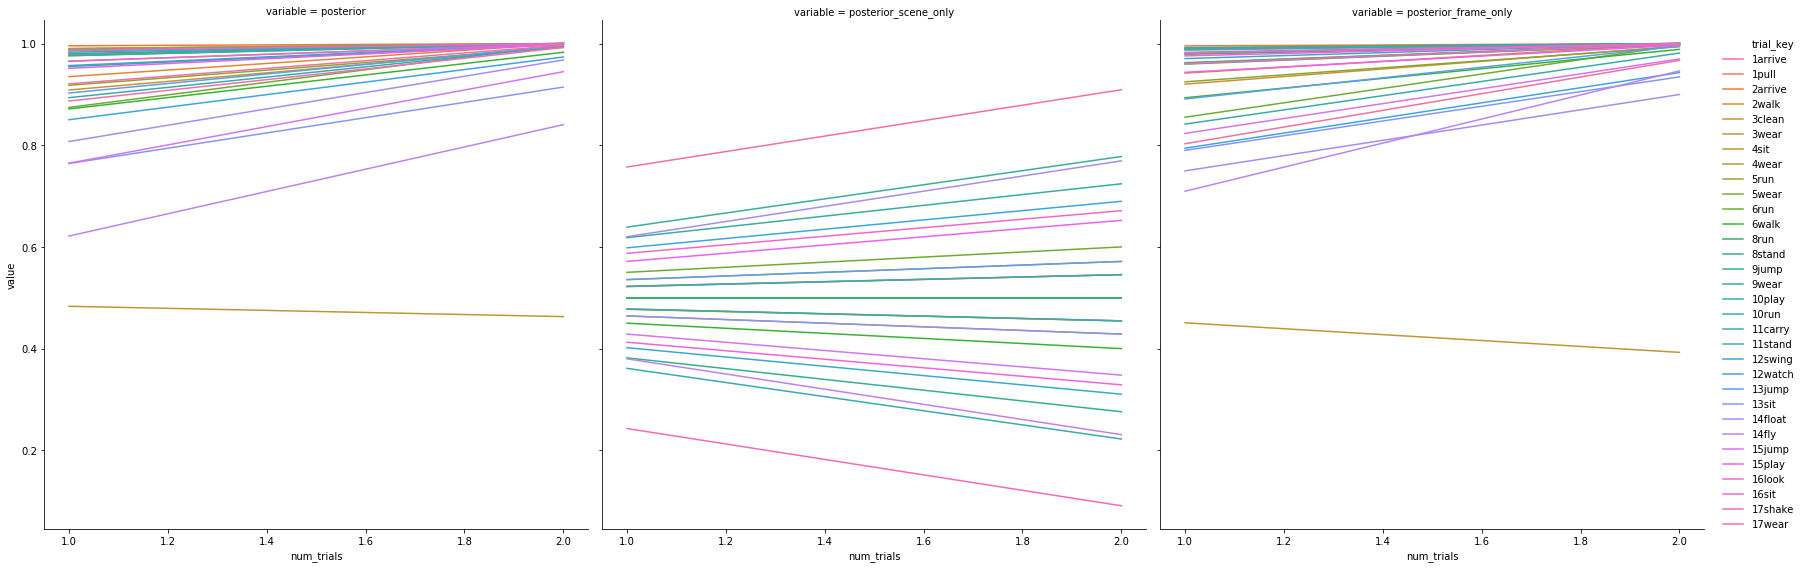

In [45]:
g = sns.FacetGrid(data=predictions.melt(id_vars=["num_trials", "item_idx", "trial_key"], value_vars=["posterior", "posterior_scene_only", "posterior_frame_only"]),
                  col="variable", height=8)
g.map(sns.lineplot, "num_trials", "value", "trial_key", ci=None).add_legend()

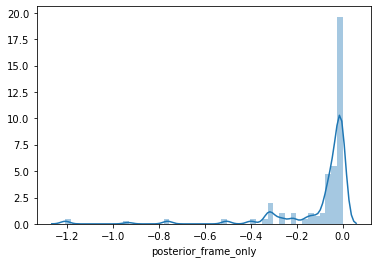

In [48]:
sns.distplot(np.log(predictions.posterior_frame_only))